In [1]:
import torch
import torch.nn as nn
from model.model import load_model, TrainableSam
from utils.config import load_config
from dataset_processing.dataset import AugmentedSamDataset, SamDatasetFromFiles, filter_dataset
from torch.utils.data import DataLoader
from dataset_processing.preprocess import collate_fn

In [2]:
config = load_config('config.toml')
prompt_type = {'points':config.dataset.points, 'box':config.dataset.box, 'neg_points':config.dataset.negative_points, 'mask':config.dataset.mask_prompt}
valid_dataset = SamDatasetFromFiles(root=config.cytomine.dataset_path,
                            #prompt_type={'points':config.dataset.points, 'box':config.dataset.box, 'neg_points':config.dataset.negative_points, 'mask':config.dataset.mask_prompt},
                            n_points=config.dataset.n_points,
                            n_neg_points=config.dataset.n_neg_points,
                            verbose=True,
                            to_dict=True,
                            use_img_embeddings=True,
                            #neg_points_inside_box=config.dataset.negative_points_inside_box,
                            #points_near_center=config.dataset.points_near_center,
                            random_box_shift=config.dataset.random_box_shift,
                            mask_prompt_type=config.dataset.mask_prompt_type,
                            #box_around_mask=config.dataset.box_around_prompt_mask,
                            load_on_cpu=True,
                            filter_files=lambda x: filter_dataset(x, [False,False,True])
)
sam_vit_b_path = '../checkpoints/sam_vit_b_01ec64.pth'
model_path = ['../checkpoints/sam_vit_b_01ec64.pth', '../checkpoints/generalisation_best_model.pt', '../checkpoints/test/finetuning.pt', '../checkpoints/test/all_best_model.pt']
dataloader = DataLoader(valid_dataset, batch_size=config.training.batch_size, shuffle=True, collate_fn=collate_fn)



4
Loading images and masks paths...
Done!


Loading model ../checkpoints/sam_vit_b_01ec64.pth
dict_keys(['image', 'original_size', 'point_coords', 'point_labels', 'boxes'])
dict_keys(['image', 'original_size', 'point_coords', 'point_labels', 'boxes'])
dict_keys(['image', 'original_size', 'point_coords', 'point_labels', 'boxes'])
dict_keys(['image', 'original_size', 'mask_inputs'])
dict_keys(['image', 'original_size', 'mask_inputs'])


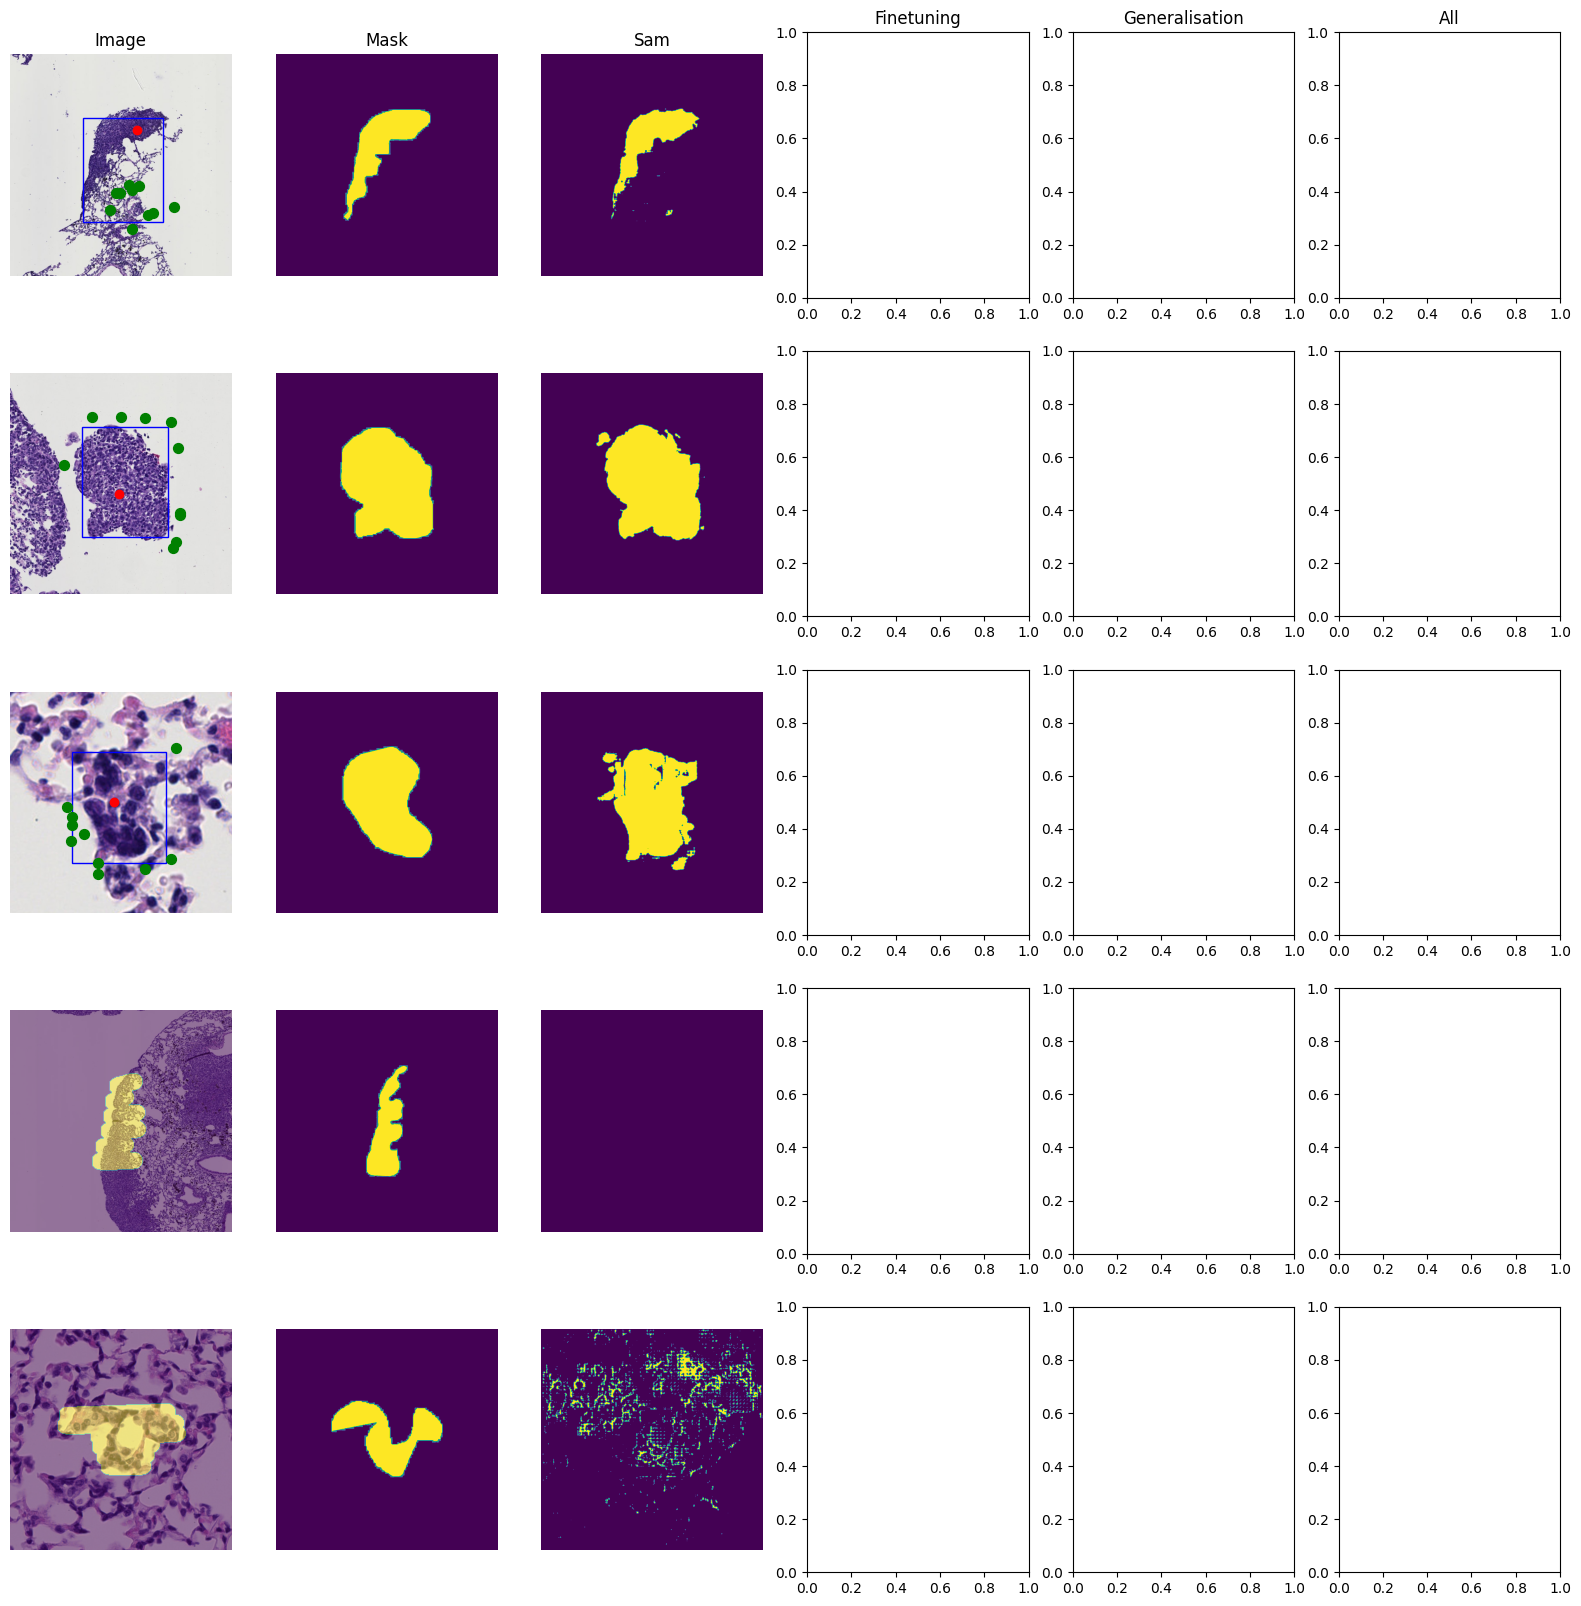

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from cv2 import resize, INTER_NEAREST
def plot_prompts(data:dict, ax) -> None:
    '''Plot the prompts'''
    print(data.keys())
    if 'mask_inputs' in data.keys():
        input_mask = resize(data['mask_inputs'].cpu().numpy()[0][0], (1024, 1024), interpolation=INTER_NEAREST)
        ax.imshow(input_mask, alpha=0.5)
    if 'boxes' in data.keys():
        box = data['boxes'][0].cpu().numpy()
        ax.add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, edgecolor='b'))
    if 'point_coords' in data.keys():

        n_positive = int(np.sum(data['point_labels'].cpu().numpy()))
        ax.scatter(data['point_coords'][:, :n_positive, 0].cpu(), data['point_coords'][:, :n_positive, 1].cpu(), c='r')
        ax.scatter(data['point_coords'][:, n_positive:, 0].cpu(), data['point_coords'][:, n_positive:, 1].cpu(), c='g', s=50)
    

model_path = ['../checkpoints/sam_vit_b_01ec64.pth',
              #'../checkpoints/test/finetuning.pt',
              #'../checkpoints/generalisation_best_model.pt',
              #'../checkpoints/test/all_best_model.pt'
              ]
n = 5
# Plot the n first samples predictions for each model
fig, axes = plt.subplots(n, 6, figsize=(20, 20))
for i, path in enumerate(model_path):
    print(f'Loading model {path}')
    model = load_model(path, img_embeddings_as_input=False, return_iou=False)
    model.to('cuda')
    model.eval()
    with torch.no_grad():
        for k, (data, mask) in enumerate(dataloader):
            pred = model(data, multimask_output=True, binary_mask_output=True)
            if k == n:
                break
            for j in range(len(pred)):
                    axes[k, 0].imshow(np.array(data[j]['image'].cpu().permute(1, 2, 0).numpy(), dtype=np.uint8))
                    plot_prompts(data[j], axes[k, 0])
                    axes[k, 0].set_axis_off()
                    axes[k, 1].imshow(mask[j])
                    axes[k, 1].set_axis_off()
                    axes[k, 2 + i].imshow(pred[j].cpu().numpy())
                    axes[k, 2 + i].set_axis_off()
                    if i==0:
                        axes[0, 0].set_title('Image')
                        axes[0, 1].set_title('Mask')
                        axes[0, 2].set_title('Sam')
                        axes[0, 3].set_title('Finetuning')
                        axes[0, 4].set_title('Generalisation')
                        axes[0, 5].set_title('All')
                    break
plt.show()
                
                